<a href="https://colab.research.google.com/github/maritnorli/IFCB_CNN_Classify/blob/main/Train_test_IFCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn

# Note: PyTorch 1.10.0+ is required for this course
torch.__version__

'2.1.0+cu121'

In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "IFCB_test_train"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)



data/IFCB_test_train does not exist, creating one...


In [5]:
# Download data from PUBLIC repository
with open(data_path / "IFCB_test_train.zip", "wb") as f: #data path= image_path  SLASH the file we are trying to open
  request = requests.get("https://github.com/maritnorli/IFCB_CNN_Classify/raw/main/data/IFCB_test_train.zip")
  print("Downloading IFCB data...")
  f.write(request.content)

with zipfile.ZipFile(data_path / "IFCB_test_train.zip", "r") as zip_ref:
  print("Unzipping IFCB_test_train data...")
  zip_ref.extractall(image_path)

Unzipping IFCB_test_train data...


## 2. Becoming one with the data (data prep and data explore)


In [6]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [7]:
walk_through_dir(image_path)

There are 1 directories and 0 images in 'data/IFCB_test_train'.
There are 2 directories and 0 images in 'data/IFCB_test_train/IFCB_test_train'.
There are 3 directories and 0 images in 'data/IFCB_test_train/IFCB_test_train/Train'.
There are 0 directories and 70 images in 'data/IFCB_test_train/IFCB_test_train/Train/Chaetoceros_decipiens_118'.
There are 0 directories and 70 images in 'data/IFCB_test_train/IFCB_test_train/Train/Tripos_muelleri_008'.
There are 0 directories and 70 images in 'data/IFCB_test_train/IFCB_test_train/Train/Guinardia_delicatula_095'.
There are 3 directories and 0 images in 'data/IFCB_test_train/IFCB_test_train/Test'.
There are 0 directories and 14 images in 'data/IFCB_test_train/IFCB_test_train/Test/Chaetoceros_decipiens_118'.
There are 0 directories and 14 images in 'data/IFCB_test_train/IFCB_test_train/Test/Tripos_muelleri_008'.
There are 0 directories and 14 images in 'data/IFCB_test_train/IFCB_test_train/Test/Guinardia_delicatula_095'.


In [8]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir


(PosixPath('data/IFCB_test_train/train'),
 PosixPath('data/IFCB_test_train/test'))

### 2.1 Visualizing and image
Let's write some code to:

1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using pathlib.Path.parent.stem
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

In [9]:
image_path

PosixPath('data/IFCB_test_train')

Random image path: data/IFCB_test_train/IFCB_test_train/Train/Chaetoceros_decipiens_118/D20230513T134712_IFCB139_00029.png
Image class: Chaetoceros_decipiens_118
Image height: 204
Image width: 448


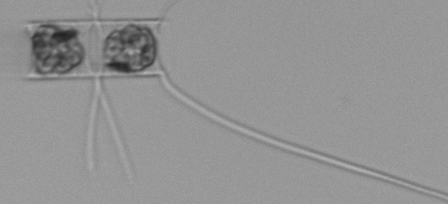

In [10]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths to folders in image_path + */*/*/*
image_path_list = list(image_path.glob("*/*/*/*.png")) #glob together all of the files that
#image_path_list #use this to check there are images in paths

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path) #this image.open will error if image is corrupt, can be used for dataset cleaning

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img


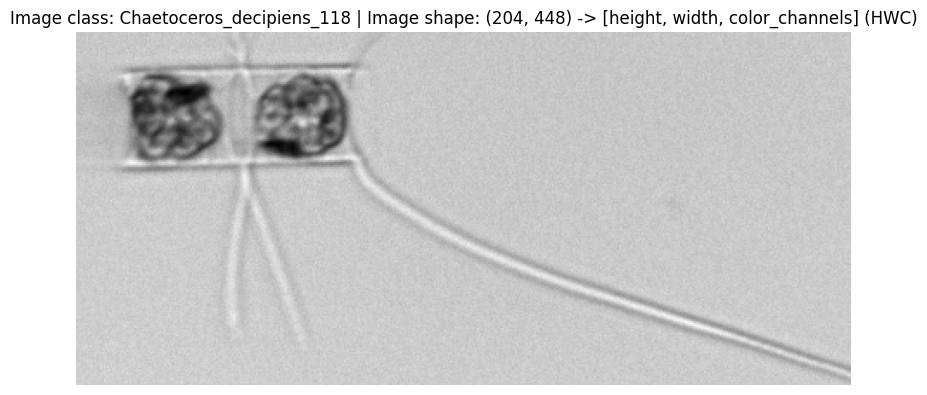

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img, cmap='gray')
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);


3. Transforming data
Before we can use our image data with PyTorch:

Turn your target data into tensors (in our case, numerical representation of our images).
Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## 3.1 Transforming data with `torchvision.transforms`
Transforms help you get your images ready to be used with a model/perform data augmentation - https://pytorch.org/vision/stable/transforms.html

In [18]:
# Write a transform for image size
data_transform = transforms.Compose([ # can also use nn.Sequential for this
  # Resize our images to 64x64 or 244 244
  transforms.Resize(size=(64, 64)),
  # Flip the images randomly on the horizontal
  transforms.RandomHorizontalFlip(p=0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor()
])

In [19]:
data_transform(img).shape

torch.Size([1, 64, 64])

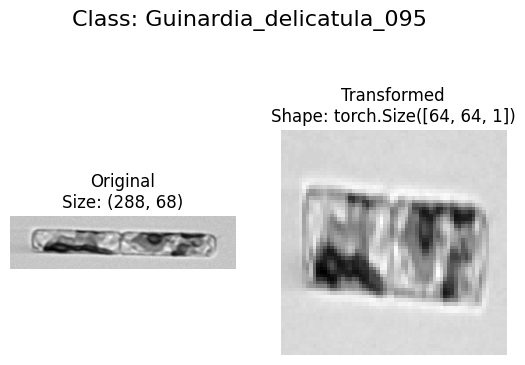

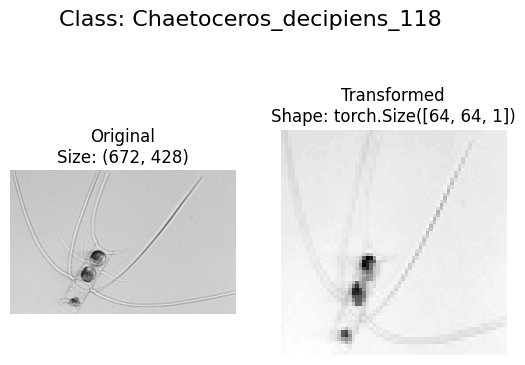

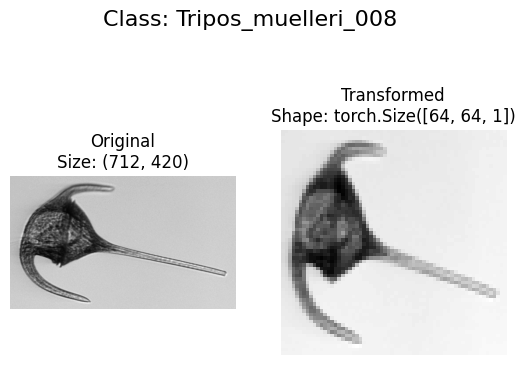

In [20]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f: #using PIL
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f, cmap='gray')
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # permute used for converting colorchannels from first to last to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image, cmap='gray')
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off") #can also write False

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)



### 4. Option 1: Loading image data using ImageFolder
We can load image classification data using torchvision.datasets.ImageFolder - https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder



In [13]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, #pass in root, transform, target
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data